<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#General-idea" data-toc-modified-id="General-idea-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>General idea</a></span></li><li><span><a href="#Gaussian-processes" data-toc-modified-id="Gaussian-processes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gaussian processes</a></span><ul class="toc-item"><li><span><a href="#Strengths-&amp;-weaknesses" data-toc-modified-id="Strengths-&amp;-weaknesses-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Strengths &amp; weaknesses</a></span><ul class="toc-item"><li><span><a href="#Strengths-of-GPs" data-toc-modified-id="Strengths-of-GPs-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Strengths of GPs</a></span></li><li><span><a href="#Weaknesses-of-GPs" data-toc-modified-id="Weaknesses-of-GPs-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Weaknesses of GPs</a></span></li></ul></li><li><span><a href="#References:" data-toc-modified-id="References:-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>References:</a></span></li><li><span><a href="#Basics" data-toc-modified-id="Basics-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Basics</a></span></li><li><span><a href="#Kernel-function-(covariance)" data-toc-modified-id="Kernel-function-(covariance)-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Kernel function (covariance)</a></span></li><li><span><a href="#Mean-and-variance" data-toc-modified-id="Mean-and-variance-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Mean and variance</a></span></li><li><span><a href="#Not-covered" data-toc-modified-id="Not-covered-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Not covered</a></span></li></ul></li><li><span><a href="#Bayesian-optimization" data-toc-modified-id="Bayesian-optimization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bayesian optimization</a></span><ul class="toc-item"><li><span><a href="#BO-for-policy-search" data-toc-modified-id="BO-for-policy-search-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>BO for policy search</a></span></li></ul></li><li><span><a href="#Prior:-mean-function" data-toc-modified-id="Prior:-mean-function-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prior: mean function</a></span></li></ul></div>

In [192]:
%matplotlib notebook
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import math
import random
plt.style.use('seaborn')



# Bayesian optimization

## General idea

The general idea of Bayesian optimization is to:
- loop:
  - build a model that predicts the fitness/reward/objective value given the points evaluated so far
  - select the most interesting point to test according to the model (balancing exploration and exploitation)
  - evaluate this point on the expensive system

## Gaussian processes

Gaussian processes is a regression method (fitting a function) that works very well when there are only a few datapoints (especially compared to neural networks). They are the most used regression model for Bayesian optimization because:
- they work well with little data (use-case of Bayesian optimization)
- they provide an estimate of the variance (uncertainty) of the prediction, which is useful to balance exploration and exploitation

### Strengths & weaknesses

#### Strengths of GPs
- very good fit with few points
- can fit noisy data
- predicts the variance (which can represent the uncertainty of the prediction)
- can incorporate priors about the data (smoothness, mean, etc.)

#### Weaknesses of GPs
- fit is $O(n^3)$ (Cholesky decomposition), more if optimizing the hyper-parameters
- query is $O(n^2)$ (with $n=$ number of samples in the training set)
- can be numerically instable if too many data points

### References:
- Online book: http://www.gaussianprocess.org/gpml/ 
- Visual exploration: https://distill.pub/2019/visual-exploration-gaussian-processes/
- Gpy: https://sheffieldml.github.io/GPy/
- GPytorch: https://docs.gpytorch.ai/en/stable/

### Basics

### Kernel function (covariance)
The kernel describes how each two points influence each other with respect to their distance. The most common idea idea is to exponentially decrease the influence with the Euclidean distance (this is the exponential-squared kernel function):
$$
k(x_1,x_2) = \sigma^2 \exp(-\frac{||x_1 - x_2||^2}{2 \ell^2})
$$ 
Where $\sigma^2$ is the overall variance (or the amplitude) and $\ell^2$ is the lengths scale. These are two hyper-parameters that can be learned from data.

Please note that there are many other kernels that either generalize this idea (Matérn) or use some prior on the data (e.g., periodic kernel with sin/cos functions).



In [193]:
def expsq(dx, alpha=(1,1)):
    sigma, ell = alpha
    return sigma**2 * np.exp(-dx**2 / (2*ell**2))

<IPython.core.display.Javascript object>


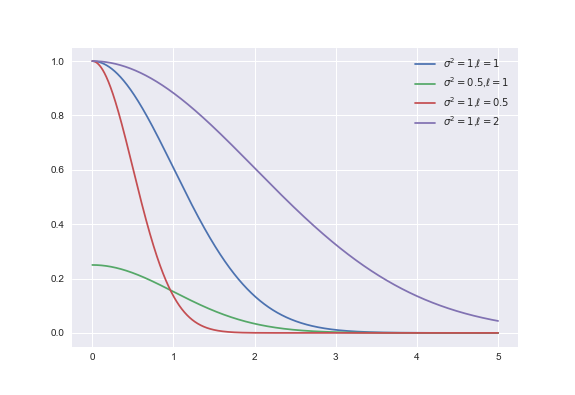

In [194]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
x = np.arange(0, 5,0.001)

ax.plot(x, expsq(x, (1,1)), label="$\sigma^2=1$,$\ell=1$")
ax.plot(x, expsq(x, (0.5,1)), label="$\sigma^2=0.5$,$\ell=1$")
ax.plot(x, expsq(x, (1,0.5)), label="$\sigma^2=1$,$\ell=0.5$")
ax.plot(x, expsq(x, (1,2)), label="$\sigma^2=1$,$\ell=2$")




plt.legend()
plt.show()


### Mean and variance

A Gaussian process is a distribution over functions that associates to every $\mathbf{x}$ a Gaussian distribution with a mean $\mu$ and a variance $\sigma$:

$$
\begin{align}
  \hat{f}_d(\mathbf{x})\sim\mathcal{GP}(\mu(\mathbf{x}),k(\mathbf{\tilde{x}},\mathbf{x}'))
\end{align}
$$

Assuming $D^d_{1:t} = \{f_d(\mathbf{x_1}),...,f_d(\mathbf{x}_t)\}$ is a set of observations (results of evaluation of the unknown reward function), we can query the GP at a new input point $\mathbf{x}_*$:

$$
\begin{align}
  p(\hat{f}(\mathbf{x}_*)|D^d_{1:t},\mathbf{\tilde{x}}_*) = \mathcal{N}(\mu(\mathbf{x}_*),\sigma^{2}(\mathbf{x}_*))
\end{align}
$$

We first compute the  kernel vector
$$\pmb{k} = \big[kernel(\mathbf{x}_1,\mathbf{x}), \cdots, kernel(\mathbf{x}_t,\mathbf{x})\big]$$

where $kernel(\mathbf{x}, \mathbf{y})$ is the kernel function (e.g., the squared exponential).

and a kernel matrix $K$, with entries 
$$K^{ij} = kernel(\mathbf{x}_i,\mathbf{x}_j)$$

$$
K = \left[\begin{matrix}
k(x1_1, x_1) & \cdots & k(x_1, x_t)\\
\vdots & \ddots & \vdots\\
k(x_t, x_1) & \cdots & k(x_t, y_t) 
\end{matrix} \right] + \sigma^2_{noise} I
$$

We can now compute the mean $\mu(x)$ and the variance $\sigma(x)$:
\begin{align}
  &\mu(\mathbf{x}) = \pmb{k}^{T}K^{-1}D^d_{1:t}\\
  &\sigma(\mathbf{x}) = k(\mathbf{x},\mathbf{x})-\pmb{k}^{T}K^{-1}\pmb{k}
\end{align}

    

In [195]:
# Some noiseless training data
x_train = np.array([-4, -3, -2, -1, 1])
y_train = np.sin(x_train)
x_test = np.linspace(-5, 5, 150)
sigma_sq = 1
ell = 1
params = (sigma_sq, ell)



In [196]:
def kernel_matrix(x1, x2, p):
    # this is to get a matrix of the distance between x1 and x2
    dx =  np.subtract.outer(x1, x2)
    return expsq(dx,p)

# Don't do this in real code -- use the Cholesky decomposition (faster, more stable)
# see the GP book, p19
def gp(x_test, x_train, y_train, p):
    K = kernel_matrix(x_train, x_train, p)  + 1e-3* np.eye(len(x_train)) # add some noise (stability)
    K_inv = np.linalg.inv(K)
    k = kernel_matrix(x_train, x_test,p)
    mu = k.T.dot(K_inv).dot(y_train)
    # this computes a lot of useless terms, but we avoid a loop (for the notebook)
    sigma = (kernel_matrix(x_test, x_test, p) - k.T.dot(K_inv).dot(k)).diagonal()
    return mu, sigma


<IPython.core.display.Javascript object>


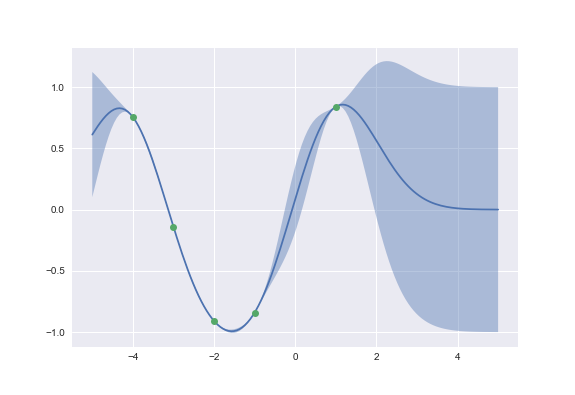

In [197]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

mu, sigma = gp(x_test, x_train, y_train, params)
plt.fill_between(x_test, mu-sigma, mu+sigma, alpha=0.4)
ax.plot(x_test, mu)
ax.plot(x_train, y_train, 'o')
plt.show()
plt.savefig("gp.pdf")

### Not covered
- Computing the mean and variance using the Cholesky decomposition (required for more than 10 points!)
- Modeling noisy data
- Optimizing the hyper-parameters ($\ell$ and $\sigma$ of the kernel function) by maximizing the log-likelihood
- Other kernel functions

In real implementations, use GPy or Gpytorch!
- GPy: https://sheffieldml.github.io/GPy/
- GPytorch: https://docs.gpytorch.ai/en/stable/

In C++, use Limbo (https://github.com/resibots/limbo).


## Bayesian optimization
Now let's try to use Gaussian processes for optimizing the parameters (e.g., the parameters of a policy).

We first need an acquisition function, which will tell us what is the most useful point. An effective and simple function is:

$$ UCB(x) = \mu(x) + \alpha \sigma(x)$$

Where $\alpha$ tunes the exploration (bigger $\alpha$ means more exploration).


<IPython.core.display.Javascript object>


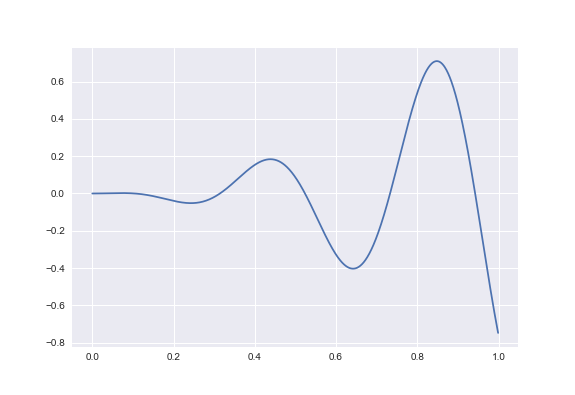

In [198]:
# a simple (unknown) function
x = np.arange(0, 1, 0.001)
def f(x):
    return np.cos(x*15) * (x**2)

plt.figure()
plt.plot(x,f(x))

<IPython.core.display.Javascript object>


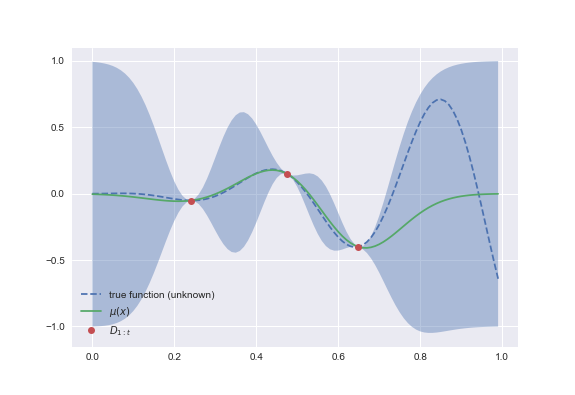

In [199]:
x = np.random.random(3)
y = f(x)
x_test = np.arange(0, 1, 0.01)
sigma_sq = 1
ell = 0.1
# ell and sigma_sq should be tuned to match 
# the magnitude of the function to optimize
# (prior knowledge)
params = (sigma_sq, ell)
mu, sigma = gp(x_test, x, y, params)

plt.figure()
plt.fill_between(x_test, mu-sigma, mu+sigma, alpha=0.4)
plt.plot(x_test, f(x_test), '--', label="true function (unknown)")
plt.plot(x_test, mu, label="$\mu(x)$")
plt.plot(x, y, 'o', label="$D_{1:t}$")
plt.legend(loc=3)




<IPython.core.display.Javascript object>


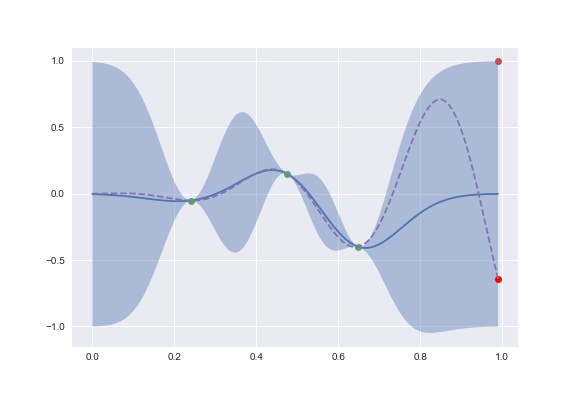

In [200]:
# now get the next point
def ucb(m, s):
    return m + s

# we should use an optimizer (e.g., CMA-ES), but we "cheat" here.
# fit the GP and find the max of UCB
mu, sigma = gp(x_test, x, y, params)
i_next = np.argmax(ucb(mu, sigma))
x_next = x_test[i_next]
y_next = f(x_next)
    

plt.figure()
plt.fill_between(x_test, mu-sigma, mu+sigma, alpha=0.4)
plt.plot(x_test, mu)
plt.plot(x, y, 'o')
plt.plot([x_next], [y_next], 'o', color='red')
plt.plot([x_next], mu[i_next]+sigma[i_next], 'o', label="UCB")
plt.plot(x_test, f(x_test), '--')





<IPython.core.display.Javascript object>


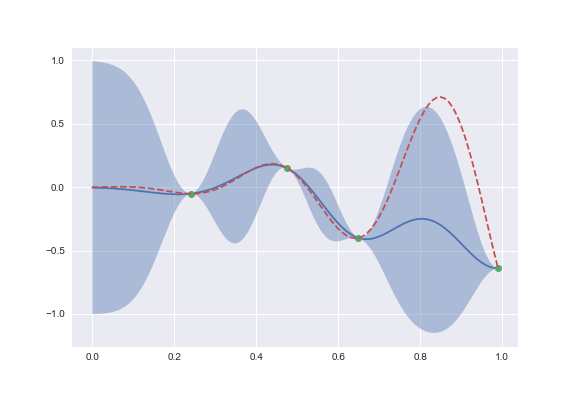

In [201]:
# update the GP
x = np.append(x, x_next)
y = np.append(y, y_next)

mu, sigma = gp(x_test, x, y, params)
    
plt.figure()
plt.fill_between(x_test, mu-sigma, mu+sigma, alpha=0.4)
plt.plot(x_test, mu)
plt.plot(x, y, 'o')
plt.plot(x_test, f(x_test), '--')


0.0 0
0.8200000000000001 82
0.8 80
0.84 84
0.84 84
0.84 84
BEST: x= 0.84 y= 0.7052010435295089  data= 10


<IPython.core.display.Javascript object>


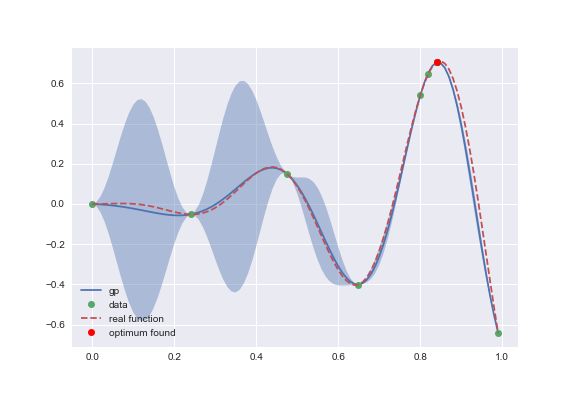

In [202]:
# do another iteration

while x.shape[0] < 10:
    mu, sigma = gp(x_test, x, y, params)
    i_next = np.argmax(ucb(mu, sigma))
    x_next = x_test[i_next]
    print(x_next, i_next)
    y_next = f(x_next)
    x = np.append(x, x_next)
    y = np.append(y, y_next)
    

mu, sigma = gp(x_test, x, y, params)


best_i = np.argmax(y)
print("BEST: x=",x[best_i], "y=",y[best_i], " data=", x.shape[0])

plt.figure()
plt.fill_between(x_test, mu-sigma, mu+sigma, alpha=0.4)
plt.plot(x_test, mu, label='gp')
plt.plot(x, y, 'o', label='data')
plt.plot(x_test, f(x_test), '--', label='real function')
plt.plot([x[best_i]], y[best_i], 'o', color='red', label='optimum found')
plt.legend(loc=3)




### BO for policy search


In [203]:
!pip install gym
!pip install pyglet==1.5.15
!pip install pyvirtualdisplay

from pyvirtualdisplay import Display
from IPython import display
pydisplay = Display(visible=0, size=(1400, 900))
pydisplay.start();

import matplotlib.pyplot as plt
%matplotlib inline
plt.ion();

  Using cached pyglet-1.5.0-py2.py3-none-any.whl (1.0 MB)
  Attempting uninstall: pyglet
    Found existing installation: pyglet 1.5.15
    Uninstalling pyglet-1.5.15:
      Successfully uninstalled pyglet-1.5.15
  Using cached pyglet-1.5.15-py3-none-any.whl (1.1 MB)
  Attempting uninstall: pyglet
    Found existing installation: pyglet 1.5.0
    Uninstalling pyglet-1.5.0:
      Successfully uninstalled pyglet-1.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gym 0.18.0 requires pyglet<=1.5.0,>=1.4.0, but you have pyglet 1.5.15 which is incompatible.


0.9229211108245774

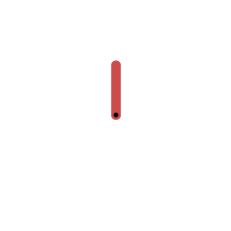

In [226]:
# basic simulation of a pendulum
# based on the GYM pendulum but:
# - we have bigger torque (otherwise no PD control)
# - the state is the angle (instead of sin/cos)
import pendulum 
import math
import numpy as np

def sim_pendulum(controller, n_steps=100, visu=False):
    env = pendulum.MyPendulumEnv()
    state = env.reset()
    if visu:
        img = plt.imshow(env.render(mode='rgb_array'))
    total_reward = 0
    for j in range(n_steps):
        action = controller.action(env.state)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if visu:
            img.set_data(env.render(mode='rgb_array')) 
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
        if done:
            return total_reward / n_steps
    return total_reward / n_steps

class PDController():
    def  __init__(self, p, d):
        self.p = p
        self.d = d        
    def action(self, state):
        return np.array([self.p * (math.pi - state[0]) - self.d * state[1]])*10.

pd = PDController(0.8, 0.1)
sim_pendulum(pd, 100, True)
            

In [187]:
!pip install gpy

In [288]:
# we use GPy (a real GP) because our "teaching implementation" is 1-D only
import GPy
# sample inputs and outputs
n_init = 2
n_iteration = 8
x = np.random.uniform(0.,1.,(n_init,2))
y = np.zeros((x.shape[0], 1))
for i in range(0, x.shape[0]):
    pd = PDController(x[i,0], x[i,1])
    y[i] = sim_pendulum(pd, 100, False)

for i in range(0, n_iteration):
    # define kernel
    ker = GPy.kern.Matern52(2,ARD=True) + GPy.kern.White(2)
    # create GP model
    m = GPy.models.GPRegression(x, y, ker, normalizer=True)
    # optimize and plot
    m.optimize(messages=False,max_f_eval = 1000)
    # search for the UCB max, using basic random search
    q = np.random.uniform(0.,1.,(5000,2))
    mu,sigma = m.predict(q)
    ucb = mu + sigma
    i_next = np.argmax(ucb)
    # evaluate the new point
    x_next = q[i_next,:]
    pd = PDController(x_next[0], x_next[1])
    y_next = sim_pendulum(pd, 100, False)
    x = np.vstack((x, [x_next]))
    y = np.vstack((y, [y_next]))
    print("BEST:", np.max(y), x[np.argmax(y)])


BEST: 0.638105220155205 [0.80398205 0.75623252]
BEST: 0.8096057264813749 [0.79560799 0.46226161]
BEST: 0.9173203377036182 [0.84805045 0.20910974]
BEST: 0.9173203377036182 [0.84805045 0.20910974]
BEST: 0.9173203377036182 [0.84805045 0.20910974]
BEST: 0.9173717795338403 [0.86535982 0.21455715]
BEST: 0.9173717795338403 [0.86535982 0.21455715]
BEST: 0.9173717795338403 [0.86535982 0.21455715]


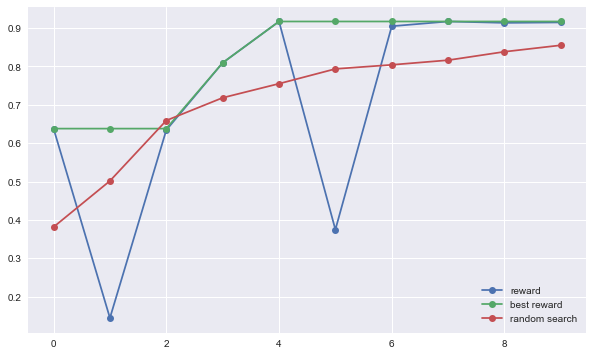

In [289]:
#plot learning progress
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, x.shape[0]), y, '-o', label='reward')
plt.plot(np.arange(0, x.shape[0]), np.maximum.accumulate(y),  '-o', label='best reward')

# compare with random search
v = np.zeros((1, y.shape[0]))
for k in range(0, 50):
    xx = np.random.uniform(0.,1.,(10,2))
    yy = np.zeros((x.shape[0], 1))
    for i in range(0, xx.shape[0]):
        pd = PDController(xx[i,0], xx[i,1])
        yy[i] = sim_pendulum(pd, 100, False)
    v = np.vstack((v, np.maximum.accumulate(yy).T))


plt.plot(np.arange(0, y.shape[0]), np.sum(v, axis=0)/v.shape[0], '-o', label='random search')
#plt.fill_between(np.arange(0, y.shape[0]), np.min(v, axis=0),  np.max(v, axis=0),alpha=0.2)
plt.legend(loc=4)




0.3932652247453497


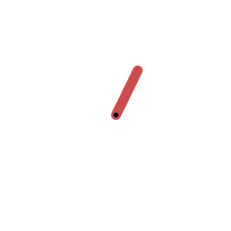

In [284]:
# simulate the best
best = x[np.argmax(y)]
pd = PDController(best[0], best[1])
f = sim_pendulum(pd, 100, True)
print(f)

In [247]:
x = np.zeros((10,1)).T
print(x)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


 /usr/local/miniconda2/envs/matplotlib/lib/python3.8/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


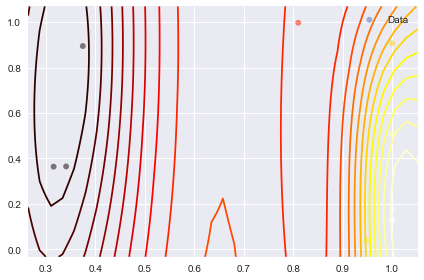

In [227]:
# plot the GP (since it's 2D)

ker = GPy.kern.Matern52(2,ARD=True) + GPy.kern.White(2)
# create GP model
m = GPy.models.GPRegression(x, y, ker, normalizer=True)
# optimize and plot
m.optimize(messages=False,max_f_eval = 1000)
mu,sigma = m.predict(q)

fig = m.plot()


## Prior: mean function

We are already using priors about our function:
- the smoothness (by the choice of the kernel)
- the variance ($\sigma^2$)

Implicitly, our current GP assumes that the mean of the signal is always 0 (reasonable assumption when we know nothing about the function). However, we can use a different value and it will make a very large difference.

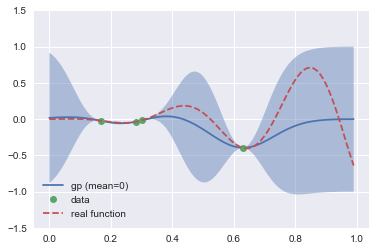

In [228]:
# define a function and some random points
def f(x):
    return np.cos(x*15) * (x**2)

x = np.random.random(4)
y = f(x)
x_test = np.arange(0, 1, 0.01)
sigma_sq = 1
ell = 0.1
params = (sigma_sq, ell)


# we add a new parameter: the mean function
def gp(x_test, x_train, y_train, mean_function, p):
    y_train = y_train - mean_function(x_train)# substract the mean before learning the GP
    # same as before
    K = kernel_matrix(x_train, x_train, p)  + 1e-3* np.eye(len(x_train)) # add some noise (stability)
    K_inv = np.linalg.inv(K)
    k = kernel_matrix(x_train, x_test,p)
    # we put the mean back
    mu = k.T.dot(K_inv).dot(y_train) + mean_function(x_test)
    sigma = (kernel_matrix(x_test, x_test, p) - k.T.dot(K_inv).dot(k)).diagonal()
    return mu, sigma


mean_0 = lambda x: 0.0
mu, sigma = gp(x_test, x, y, mean_0, params)




plt.figure()
plt.fill_between(x_test, mu-sigma, mu+sigma, alpha=0.4)
plt.ylim((-1.5,1.5))
plt.plot(x_test, mu, label='gp (mean=0)')
plt.plot(x, y, 'o', label='data')
plt.plot(x_test, f(x_test), '--', label='real function')
plt.legend(loc=3)

plt.legend(loc=3)






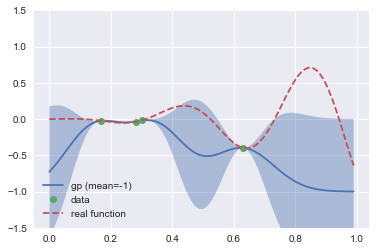

In [229]:
# same thing, but with a different mean function (-1):

mean_0 = lambda x: -1
mu, sigma = gp(x_test, x, y, mean_0, params)

plt.figure()
plt.fill_between(x_test, mu-sigma, mu+sigma, alpha=0.4)
plt.ylim((-1.5,1.5))
plt.plot(x_test, mu, label='gp (mean=-1)')
plt.plot(x, y, 'o', label='data')
plt.plot(x_test, f(x_test), '--', label='real function')
plt.legend(loc=3)



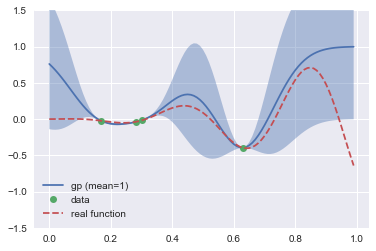

In [230]:
# now with a mean = 1
# same thing, but with a different mean function (-1):


mean_0 = lambda x: 1
mu, sigma = gp(x_test, x, y, mean_0, params)

plt.figure()
plt.fill_between(x_test, mu-sigma, mu+sigma, alpha=0.4)
plt.plot(x_test, mu, label='gp (mean=1)')
plt.plot(x, y, 'o', label='data')
plt.plot(x_test, f(x_test), '--', label='real function')
plt.ylim((-1.5,1.5))
plt.legend(loc=3)

